In [3]:
!pip install pytesseract pdf2image -q
!apt-get install -y tesseract-ocr tesseract-ocr-ara poppler-utils > /dev/null

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd

BASE_PATH = "/content/drive/MyDrive/Assesment-data"

train_df = pd.read_csv(os.path.join(BASE_PATH, "train_doc_split.csv"))
val_df   = pd.read_csv(os.path.join(BASE_PATH, "val_doc_split.csv"))

ROOT_DIR = os.path.join(BASE_PATH, "pages_raw")

print("Train:", len(train_df))
print("Val:", len(val_df))

Mounted at /content/drive
Train: 740
Val: 219


In [5]:
classes = sorted(train_df["label"].unique())

label2idx = {c:i for i,c in enumerate(classes)}
idx2label = {v:k for k,v in label2idx.items()}

train_df["label_idx"] = train_df["label"].map(label2idx)
val_df["label_idx"]   = val_df["label"].map(label2idx)

NUM_CLASSES = len(classes)

print(classes)

['Financial Sheets', "Independent Auditor's Report", 'Notes (Tabular)', 'Notes (Text)', 'Other Pages']


In [6]:
from torchvision import transforms

IMG_SIZE = 384  # 👈 رفعنا الدقة

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomAdjustSharpness(2, p=0.5),  # 👈 جديد للجداول
    transforms.ColorJitter(brightness=0.05, contrast=0.05),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])

In [7]:
from torch.utils.data import Dataset
from PIL import Image

class DocDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]["image_name"]
        label = self.df.iloc[idx]["label_idx"]

        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    DocDataset(train_df, ROOT_DIR, train_transform),
    batch_size=8,  # 👈 كان 32
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    DocDataset(val_df, ROOT_DIR, val_transform),
    batch_size=8,
    shuffle=False,
    num_workers=2
)

In [9]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.efficientnet_b0(pretrained=True)

for param in model.parameters():
    param.requires_grad = True

model.classifier[1] = nn.Linear(
    model.classifier[1].in_features,
    NUM_CLASSES
)

model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 116MB/s] 


In [10]:
class_counts = train_df['label_idx'].value_counts().sort_index()
weights = 1.0 / class_counts
weights = torch.tensor(weights.values, dtype=torch.float)

weights = weights / weights.sum() * len(weights)
weights = weights.to(device)

criterion = nn.CrossEntropyLoss(weight=weights)

print("Weights:", weights)

Weights: tensor([1.0588, 1.2554, 0.2600, 0.4287, 1.9972], device='cuda:0')


In [11]:
import torch.optim as optim
from sklearn.metrics import f1_score
import copy
import time

optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)

EPOCHS = 15
best_f1 = 0
best_model_state = copy.deepcopy(model.state_dict())

for epoch in range(EPOCHS):

    start = time.time()
    model.train()

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)

            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_f1 = f1_score(all_labels, all_preds, average="macro")

    print(f"Epoch {epoch+1} | Val Macro F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_state = copy.deepcopy(model.state_dict())
        torch.save(best_model_state, "/content/best_sukuk_model.pth")
        print("✅ Saved best model")

print("🔥 Best F1:", best_f1)

Epoch 1 | Val Macro F1: 0.7134
✅ Saved best model
Epoch 2 | Val Macro F1: 0.7662
✅ Saved best model
Epoch 3 | Val Macro F1: 0.8289
✅ Saved best model
Epoch 4 | Val Macro F1: 0.8794
✅ Saved best model
Epoch 5 | Val Macro F1: 0.8998
✅ Saved best model
Epoch 6 | Val Macro F1: 0.8996
Epoch 7 | Val Macro F1: 0.9203
✅ Saved best model
Epoch 8 | Val Macro F1: 0.9353
✅ Saved best model
Epoch 9 | Val Macro F1: 0.9458
✅ Saved best model
Epoch 10 | Val Macro F1: 0.9507
✅ Saved best model
Epoch 11 | Val Macro F1: 0.9583
✅ Saved best model
Epoch 12 | Val Macro F1: 0.9557
Epoch 13 | Val Macro F1: 0.9558
Epoch 14 | Val Macro F1: 0.9678
✅ Saved best model
Epoch 15 | Val Macro F1: 0.9637
🔥 Best F1: 0.9678270499301844


In [12]:
!pip install pytesseract pdf2image -q
!apt-get install -y tesseract-ocr tesseract-ocr-ara poppler-utils > /dev/null

In [17]:
import pytesseract
import numpy as np
import re


def clean_text(text):
    text = text.replace("\n", " ")
    text = text.replace("ـ", "")
    text = re.sub(r"\s+", " ", text)
    return text.strip()


def ocr_read_title(img):

    width, height = img.size
    cropped = img.crop((0, 0, width, int(height * 0.39)))

    data = pytesseract.image_to_data(
        cropped,
        lang="ara",
        output_type=pytesseract.Output.DICT
    )

    words = []
    confidences = []

    for i in range(len(data["text"])):
        word = data["text"][i].strip()
        conf = int(data["conf"][i])

        if word != "" and conf > 0:
            words.append(word)
            confidences.append(conf)

    if len(confidences) == 0:
        return "", 0, None

    avg_conf = np.mean(confidences)
    full_text = clean_text(" ".join(words))

    # 👇 نركز فقط على أول 150 حرف (غالباً العنوان)
    title_part = full_text[:150]

    # ===== المطابقة الآن تكون على العنوان فقط =====

    if "تقرير المراجع المستقل" in title_part:
        return full_text, avg_conf, "auditor"

    if "قائمة المركز المالي" in title_part:
        return full_text, avg_conf, "financial"

    if "قائمة الدخل" in title_part:
        return full_text, avg_conf, "financial"

    if "قائمة التدفقات النقدية" in title_part:
        return full_text, avg_conf, "financial"

    if "قائمة التغيرات في حقوق الملكية" in title_part:
        return full_text, avg_conf, "financial"

    if "إيضاحات حول القوائم المالية" in title_part:
        return full_text, avg_conf, "notes"

    return full_text, avg_conf, None

In [18]:
inference_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])


Page 1
OCR: None | conf: 0
CNN after mask: {'Financial Sheets': np.float32(0.0), "Independent Auditor's Report": np.float32(0.0), 'Notes (Tabular)': np.float32(0.001), 'Notes (Text)': np.float32(0.005), 'Other Pages': np.float32(0.994)}
FINAL: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.0), 'Notes (Text)': np.float64(0.003), 'Other Pages': np.float64(0.646)}
Prediction: Other Pages


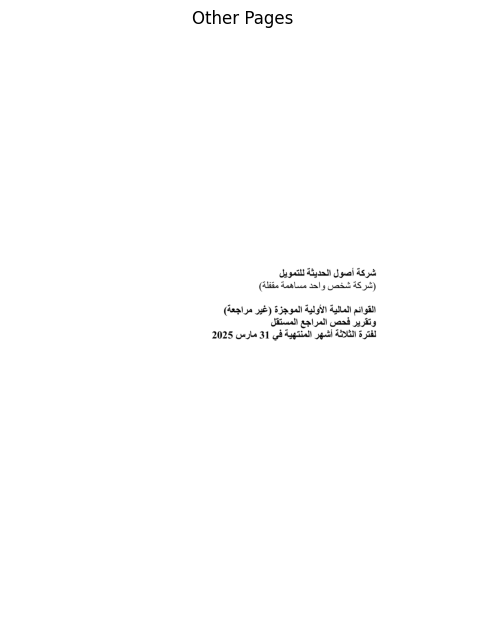


Page 2
OCR: None | conf: 91.5
CNN after mask: {'Financial Sheets': np.float32(0.0), "Independent Auditor's Report": np.float32(0.0), 'Notes (Tabular)': np.float32(0.0), 'Notes (Text)': np.float32(0.001), 'Other Pages': np.float32(0.999)}
FINAL: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.0), 'Notes (Text)': np.float64(0.001), 'Other Pages': np.float64(0.649)}
Prediction: Other Pages


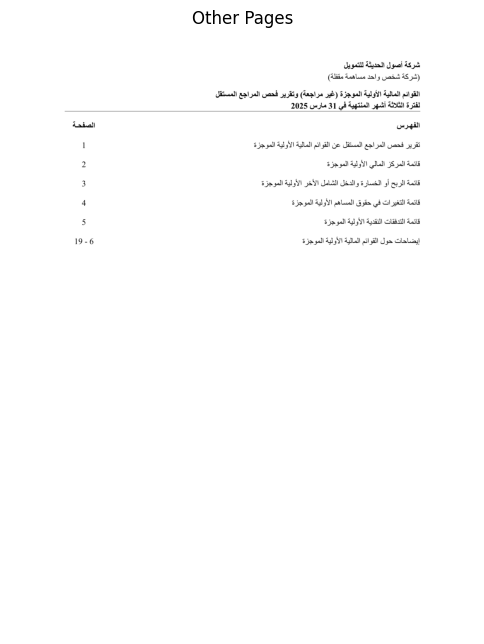


Page 3
OCR: None | conf: 88.4
CNN after mask: {'Financial Sheets': np.float32(0.004), "Independent Auditor's Report": np.float32(0.994), 'Notes (Tabular)': np.float32(0.001), 'Notes (Text)': np.float32(0.0), 'Other Pages': np.float32(0.0)}
FINAL: {'Financial Sheets': np.float64(0.003), "Independent Auditor's Report": np.float64(0.646), 'Notes (Tabular)': np.float64(0.001), 'Notes (Text)': np.float64(0.0), 'Other Pages': np.float64(0.0)}
Prediction: Independent Auditor's Report


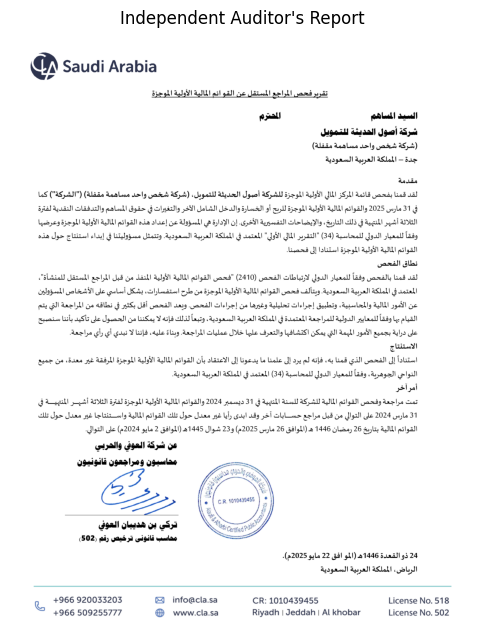


Page 4
OCR: None | conf: 77.2
CNN after mask: {'Financial Sheets': np.float32(0.877), "Independent Auditor's Report": np.float32(0.001), 'Notes (Tabular)': np.float32(0.12), 'Notes (Text)': np.float32(0.0), 'Other Pages': np.float32(0.002)}
FINAL: {'Financial Sheets': np.float64(0.57), "Independent Auditor's Report": np.float64(0.001), 'Notes (Tabular)': np.float64(0.078), 'Notes (Text)': np.float64(0.0), 'Other Pages': np.float64(0.001)}
Prediction: Financial Sheets


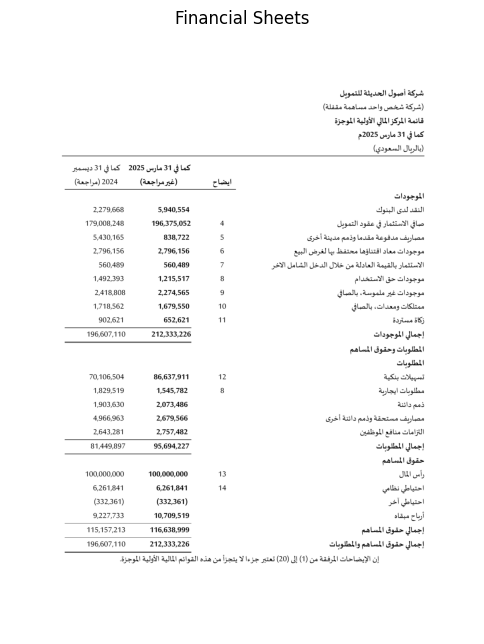


Page 5
OCR: None | conf: 82.5
CNN after mask: {'Financial Sheets': np.float32(0.82), "Independent Auditor's Report": np.float32(0.002), 'Notes (Tabular)': np.float32(0.17), 'Notes (Text)': np.float32(0.001), 'Other Pages': np.float32(0.008)}
FINAL: {'Financial Sheets': np.float64(0.533), "Independent Auditor's Report": np.float64(0.001), 'Notes (Tabular)': np.float64(0.11), 'Notes (Text)': np.float64(0.001), 'Other Pages': np.float64(0.005)}
Prediction: Financial Sheets


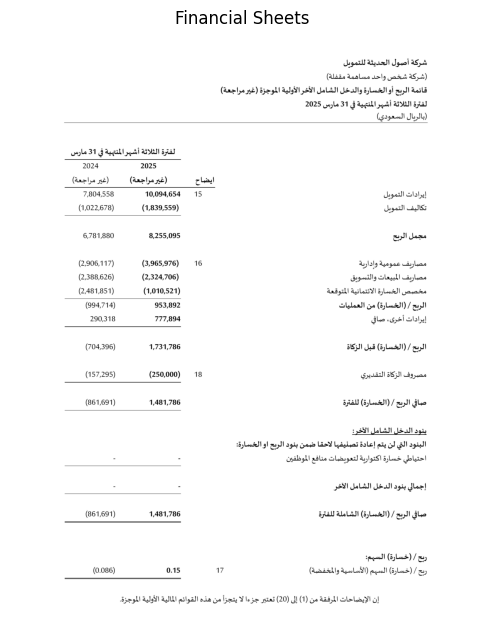


Page 6
OCR: None | conf: 88.7
CNN after mask: {'Financial Sheets': np.float32(0.276), "Independent Auditor's Report": np.float32(0.008), 'Notes (Tabular)': np.float32(0.7), 'Notes (Text)': np.float32(0.01), 'Other Pages': np.float32(0.006)}
FINAL: {'Financial Sheets': np.float64(0.179), "Independent Auditor's Report": np.float64(0.005), 'Notes (Tabular)': np.float64(0.455), 'Notes (Text)': np.float64(0.007), 'Other Pages': np.float64(0.004)}
Prediction: Notes (Tabular)


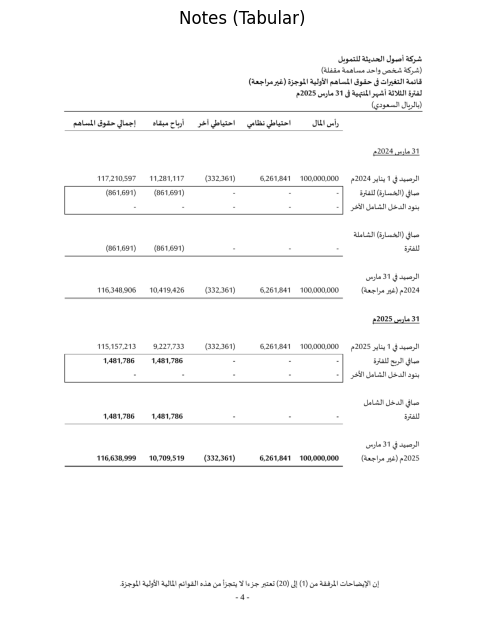


Page 7
OCR: financial | conf: 79.3
CNN after mask: {'Financial Sheets': np.float32(0.628), "Independent Auditor's Report": np.float32(0.006), 'Notes (Tabular)': np.float32(0.349), 'Notes (Text)': np.float32(0.005), 'Other Pages': np.float32(0.011)}
FINAL: {'Financial Sheets': np.float64(0.686), "Independent Auditor's Report": np.float64(0.004), 'Notes (Tabular)': np.float64(0.227), 'Notes (Text)': np.float64(0.003), 'Other Pages': np.float64(0.007)}
Prediction: Financial Sheets


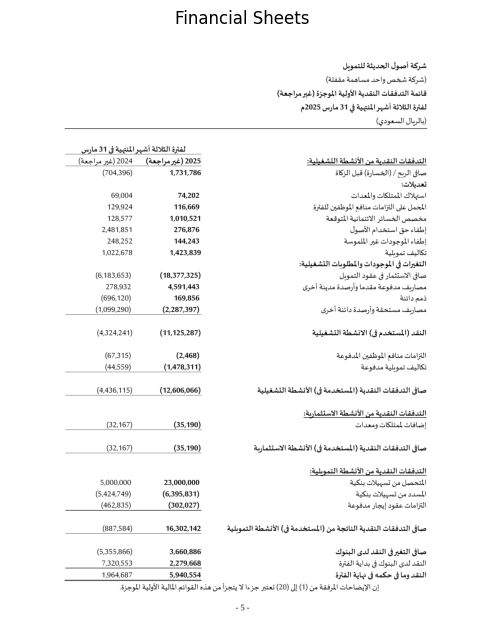


Page 8
OCR: notes | conf: 89.3
CNN after mask: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.008), 'Notes (Text)': np.float64(0.985), 'Other Pages': np.float64(0.0)}
FINAL: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.162), 'Notes (Text)': np.float64(0.797), 'Other Pages': np.float64(0.0)}
Prediction: Notes (Text)


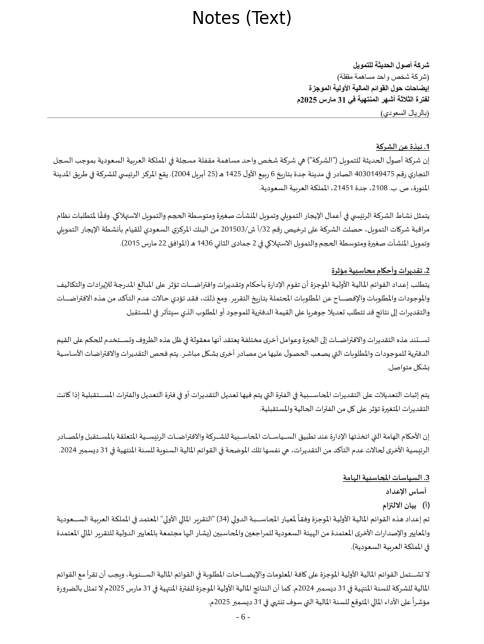


Page 9
OCR: notes | conf: 90.6
CNN after mask: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.228), 'Notes (Text)': np.float64(0.007), 'Other Pages': np.float64(0.0)}
FINAL: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.307), 'Notes (Text)': np.float64(0.163), 'Other Pages': np.float64(0.0)}
Prediction: Notes (Tabular)


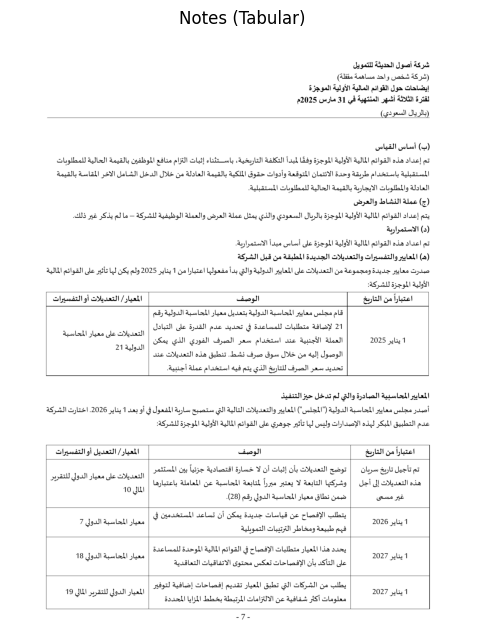


Page 10
OCR: notes | conf: 88.3
CNN after mask: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.011), 'Notes (Text)': np.float64(0.984), 'Other Pages': np.float64(0.0)}
FINAL: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.162), 'Notes (Text)': np.float64(0.794), 'Other Pages': np.float64(0.0)}
Prediction: Notes (Text)


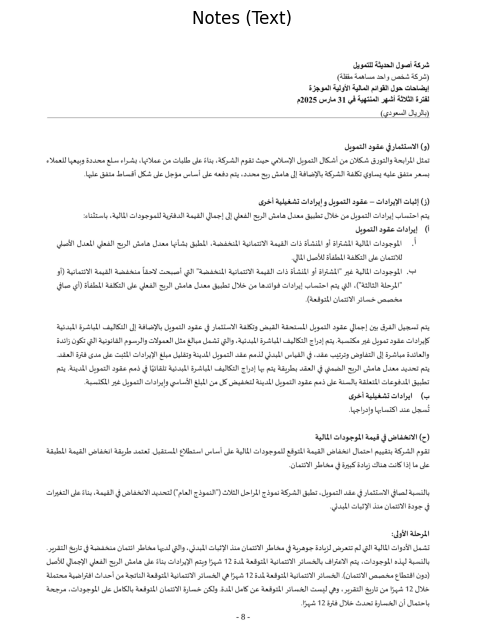


Page 11
OCR: notes | conf: 88.5
CNN after mask: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.97), 'Notes (Text)': np.float64(0.024), 'Other Pages': np.float64(0.0)}
FINAL: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.785), 'Notes (Text)': np.float64(0.171), 'Other Pages': np.float64(0.0)}
Prediction: Notes (Tabular)


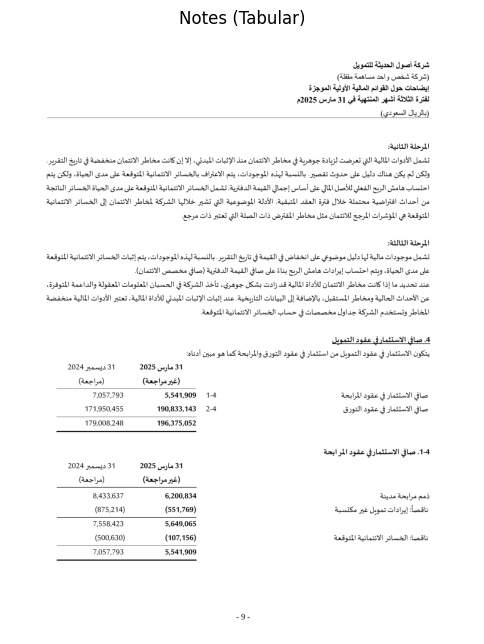


Page 12
OCR: notes | conf: 86.7
CNN after mask: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.99), 'Notes (Text)': np.float64(0.001), 'Other Pages': np.float64(0.0)}
FINAL: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.795), 'Notes (Text)': np.float64(0.152), 'Other Pages': np.float64(0.0)}
Prediction: Notes (Tabular)


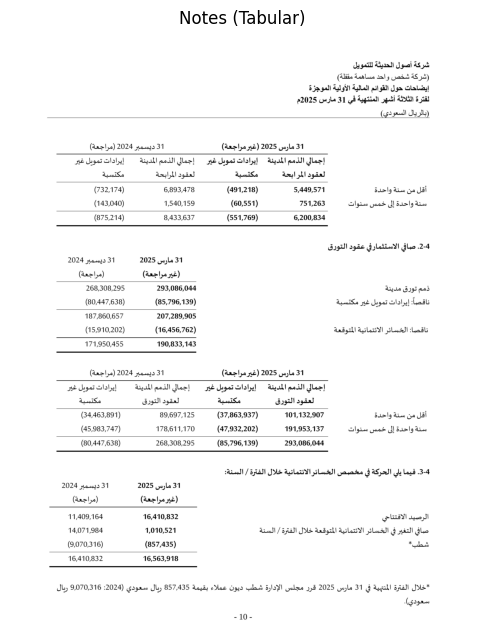


Page 13
OCR: notes | conf: 88.4
CNN after mask: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.999), 'Notes (Text)': np.float64(0.001), 'Other Pages': np.float64(0.0)}
FINAL: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.804), 'Notes (Text)': np.float64(0.155), 'Other Pages': np.float64(0.0)}
Prediction: Notes (Tabular)


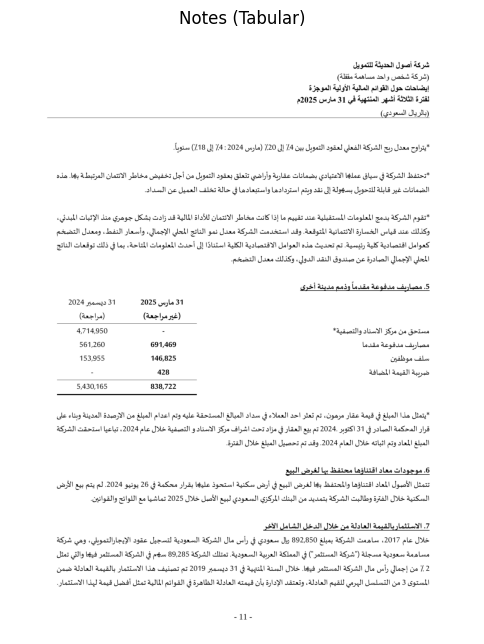


Page 14
OCR: notes | conf: 90.8
CNN after mask: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.931), 'Notes (Text)': np.float64(0.044), 'Other Pages': np.float64(0.0)}
FINAL: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.764), 'Notes (Text)': np.float64(0.188), 'Other Pages': np.float64(0.0)}
Prediction: Notes (Tabular)


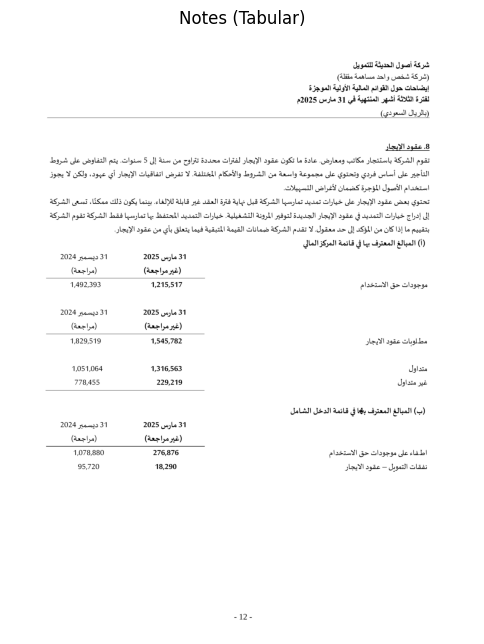


Page 15
OCR: notes | conf: 87.3
CNN after mask: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.997), 'Notes (Text)': np.float64(0.0), 'Other Pages': np.float64(0.0)}
FINAL: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.801), 'Notes (Text)': np.float64(0.153), 'Other Pages': np.float64(0.0)}
Prediction: Notes (Tabular)


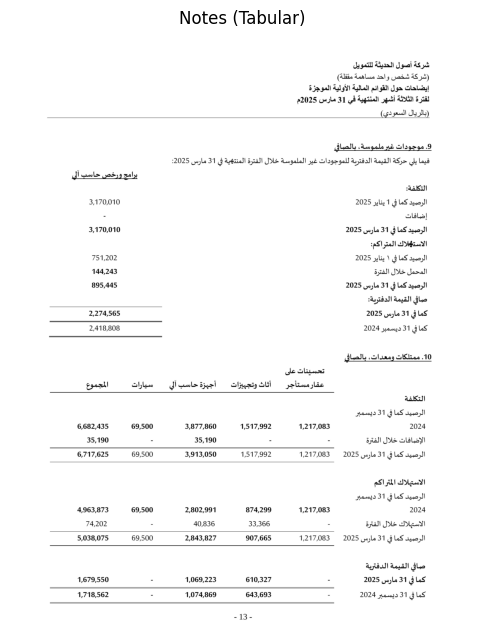


Page 16
OCR: notes | conf: 87.8
CNN after mask: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.611), 'Notes (Text)': np.float64(0.36), 'Other Pages': np.float64(0.0)}
FINAL: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.551), 'Notes (Text)': np.float64(0.387), 'Other Pages': np.float64(0.0)}
Prediction: Notes (Tabular)


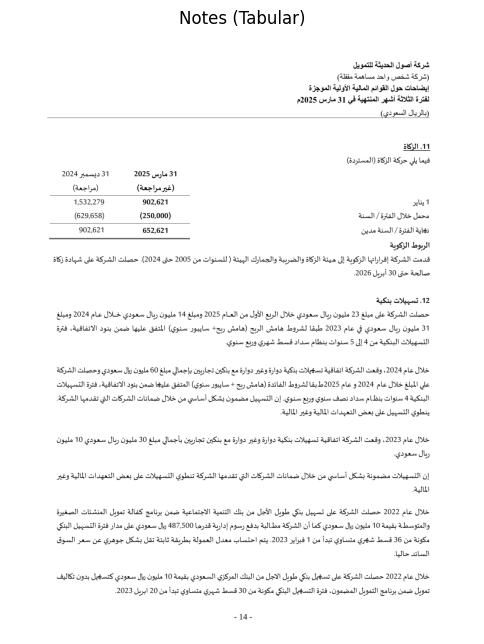


Page 17
OCR: notes | conf: 80.9
CNN after mask: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.994), 'Notes (Text)': np.float64(0.002), 'Other Pages': np.float64(0.0)}
FINAL: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.788), 'Notes (Text)': np.float64(0.143), 'Other Pages': np.float64(0.0)}
Prediction: Notes (Tabular)


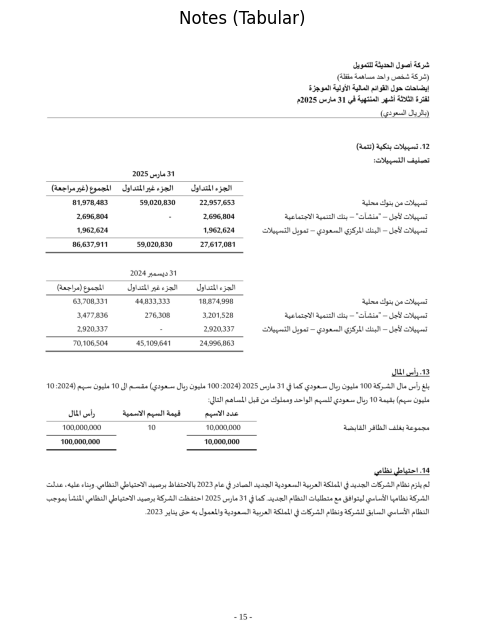


Page 18
OCR: notes | conf: 84.6
CNN after mask: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.996), 'Notes (Text)': np.float64(0.001), 'Other Pages': np.float64(0.0)}
FINAL: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.795), 'Notes (Text)': np.float64(0.149), 'Other Pages': np.float64(0.0)}
Prediction: Notes (Tabular)


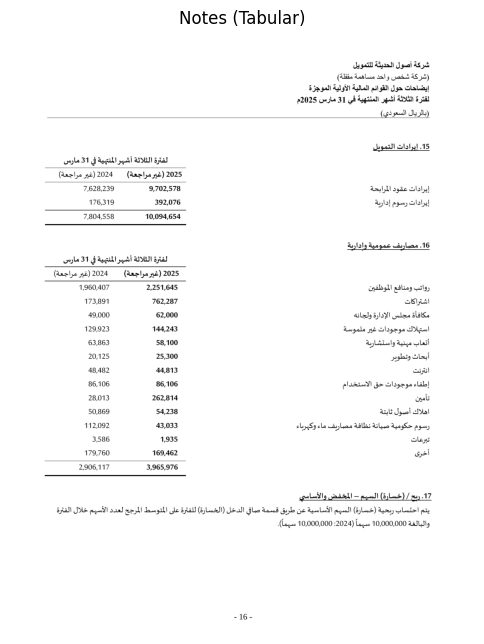


Page 19
OCR: notes | conf: 89.8
CNN after mask: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.015), 'Notes (Text)': np.float64(0.966), 'Other Pages': np.float64(0.0)}
FINAL: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.167), 'Notes (Text)': np.float64(0.785), 'Other Pages': np.float64(0.0)}
Prediction: Notes (Text)


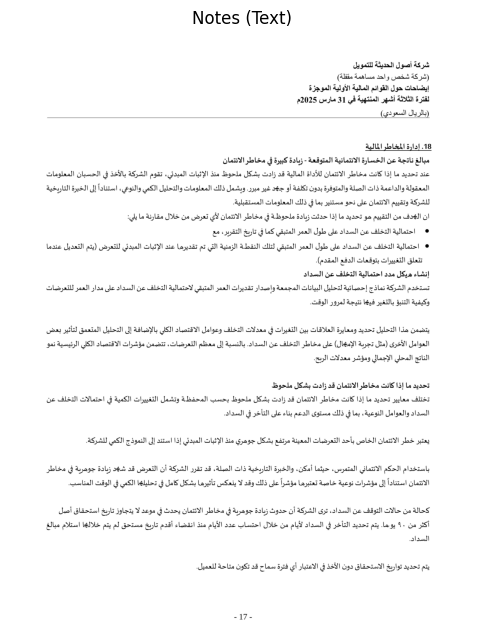


Page 20
OCR: notes | conf: 87.9
CNN after mask: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.069), 'Notes (Text)': np.float64(0.91), 'Other Pages': np.float64(0.0)}
FINAL: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.199), 'Notes (Text)': np.float64(0.745), 'Other Pages': np.float64(0.0)}
Prediction: Notes (Text)


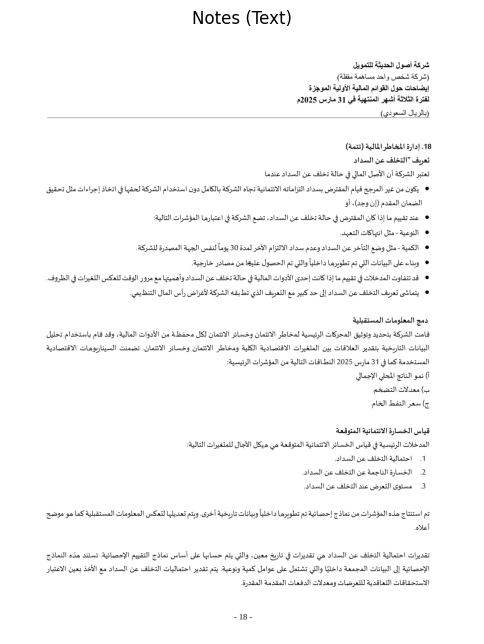


Page 21
OCR: notes | conf: 91.1
CNN after mask: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.007), 'Notes (Text)': np.float64(0.987), 'Other Pages': np.float64(0.0)}
FINAL: {'Financial Sheets': np.float64(0.0), "Independent Auditor's Report": np.float64(0.0), 'Notes (Tabular)': np.float64(0.164), 'Notes (Text)': np.float64(0.801), 'Other Pages': np.float64(0.0)}
Prediction: Notes (Text)


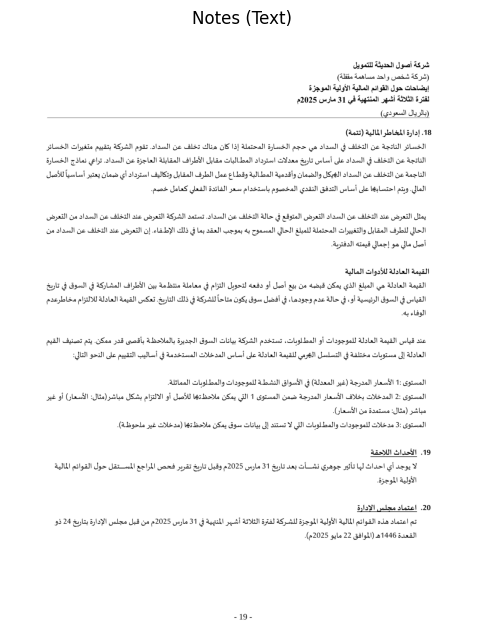

In [20]:
from pdf2image import convert_from_path
import torch
import matplotlib.pyplot as plt
import numpy as np

pdf_path = "القوائم-المالية-الأولية-الموجزة-لشركة-أصول-الحديثة-للتمويل-لفترة-الثلاثة-أشهر-المنتهية-في-31-مارس-2025.pdf"
pages = convert_from_path(pdf_path, dpi=200)

model.load_state_dict(torch.load("/content/best_sukuk_model.pth"))
model.eval()

w_cnn = 0.65
w_ocr = 0.35

predictions = []

for i, page in enumerate(pages):

    img = page.convert("RGB")

    # ===== 1️⃣ CNN =====
    img_tensor = inference_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        cnn_probs = torch.softmax(outputs, dim=1)[0].cpu().numpy()

    # ===== 2️⃣ OCR =====
    text, ocr_conf, detected_type = ocr_read_title(img)
    conf_factor = ocr_conf / 100.0

    ocr_scores = np.zeros(len(classes))

    if detected_type == "auditor":
        ocr_scores[classes.index("Independent Auditor's Report")] = conf_factor

    elif detected_type == "financial":
        ocr_scores[classes.index("Financial Sheets")] = conf_factor

    elif detected_type == "notes":
        # نعطي نصف الاحتمال لكل نوع
        ocr_scores[classes.index("Notes (Text)")] = 0.5 * conf_factor
        ocr_scores[classes.index("Notes (Tabular)")] = 0.5 * conf_factor

        # 🔥 Logical Constraint: منع باقي الكلاسات
        mask = np.zeros(len(classes))
        mask[classes.index("Notes (Text)")] = 1
        mask[classes.index("Notes (Tabular)")] = 1

        cnn_probs = cnn_probs * mask

    # ===== 3️⃣ Fusion بعد الماسك =====
    final_scores = (w_cnn * cnn_probs) + (w_ocr * ocr_scores)

    final_idx = np.argmax(final_scores)
    predicted_label = classes[final_idx]

    predictions.append(predicted_label)

    # ===== Debug Output =====
    print(f"\nPage {i+1}")
    print("OCR:", detected_type, "| conf:", round(ocr_conf,1))
    print("CNN after mask:", dict(zip(classes, np.round(cnn_probs,3))))
    print("FINAL:", dict(zip(classes, np.round(final_scores,3))))
    print("Prediction:", predicted_label)

    plt.figure(figsize=(6,8))
    plt.imshow(img)
    plt.title(predicted_label)
    plt.axis("off")
    plt.show()